In [94]:
%load_ext autoreload
%autoreload 2

import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import diffcp
import itertools
from scipy.special import logsumexp

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

BAD_RXNS = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25.",
            "DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.",
            'DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.']


from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [95]:
time = '10'
date = '2023-04-24'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [96]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [97]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [98]:
type = 'ecoli-metabolism-redux'

if type == 'ecoli-metabolism-redux':
    metabolism = agent['ecoli-metabolism-redux']
    stoichiometry = metabolism.stoichiometry
    stoichiometric_matrix_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}
elif type == 'ecoli-metabolism':
    stoichiometry = agent['ecoli-metabolism'].model.stoichiometry
    maintenance_reaction = agent['ecoli-metabolism'].model.maintenance_reaction
    stoichiometry["maintenance_reaction"] = maintenance_reaction


# for rxn in BAD_RXNS:
#     stoichiometric_matrix_dict.pop(rxn, None)

Pandas automatically understands dicts of dicts as matrices.

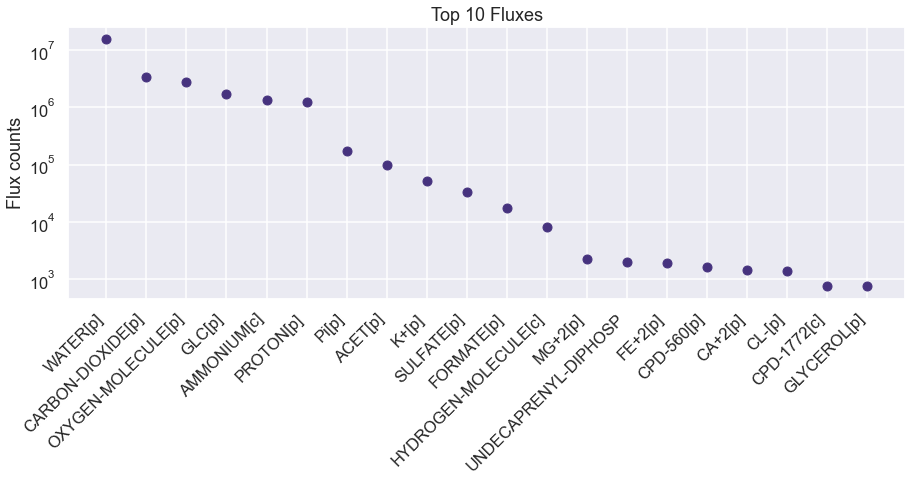

In [99]:
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[4, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

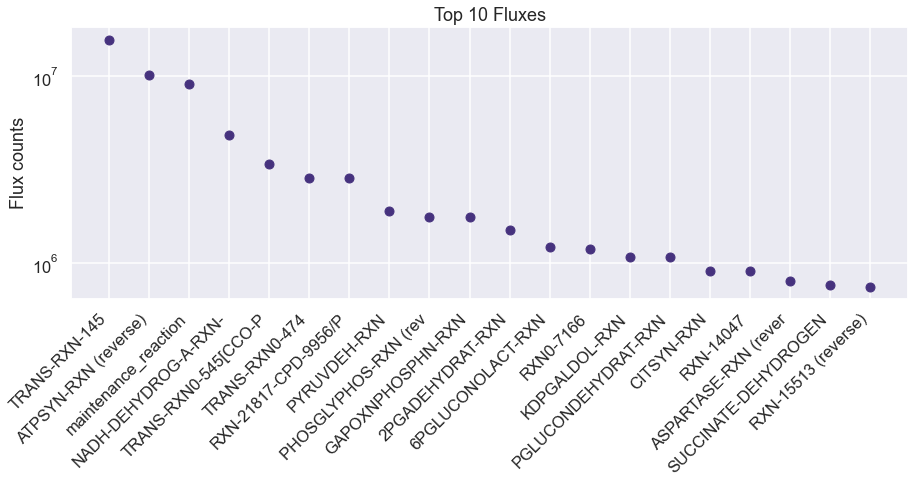

In [100]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))


# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
# log scale
plt.yscale('log')
plt.title('Top 10 Fluxes')
plt.show()

In [101]:
sim_fluxes.head(20)

,4
TRANS-RXN-145,15664870.0
ATPSYN-RXN (reverse),10130784.0
maintenance_reaction,9067240.0
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,4844282.0
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),3409951.0
TRANS-RXN0-474,2843214.0
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.,2837267.0
PYRUVDEH-RXN,1904459.0
PHOSGLYPHOS-RXN (reverse),1777426.0
GAPOXNPHOSPHN-RXN,1777414.0


In [102]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"])
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
RXN0-1741-MALTOSE//MALTOSE.17.,40249
RXN-15315,40223
TRANS-RXN0-445-CHITOBIOSE//CHITOBIOSE.23.,40223
RXN0-0-N-ACETYLNEURAMINATE//N-ACETYLNEURAMINATE.41.,40223
RXN0-0-N-ACETYLNEURAMINATE//CPD0-1123.31.,40223
...,...
TRANS-RXN-100,0
RXN-17726-CPD-3561/WATER//GALACTOSE/CPD-10723.36.,0
RXN-17726-CPD-3561/WATER//GALACTOSE/BETA-D-FRUCTOSE.42.,0
RXN-17726,0


# Test changing nutrient composition

In [103]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        # "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  # "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'GLC[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [104]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["maintenance_target"]).at[4, 'maintenance_reaction']
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]     73.0
2-KETOGLUTARATE[c]          186.0
2-PG[c]                      49.0
2K-4CH3-PENTANOATE[c]        73.0
4-AMINO-BUTYRATE[c]         160.0
                            ...  
MN+2[p]                      52.0
NA+[p]                       52.0
OXYGEN-MOLECULE[p]           51.0
CA+2[p]                      52.0
Pi[p]                        52.0
Name: 4, Length: 171, dtype: float64

# Use parametrized method

In [105]:
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult
model = NetworkFlowModel(reactions=stoichiometric_matrix_dict,
                         homeostatic_metabolites=metabolism.homeostatic_objective,
                         kinetic_reactions=metabolism.kinetic_constraint_reactions,
                         free_reactions='TRANS-RXN-145')


In [106]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [107]:
model.set_up_problem(objective_weights={'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001})

In [108]:
solution: FlowResult = model.solve_parametrized(homeostatic_targets=dict(homeostatic),
                                                maintenance_target=maintenance,
                                                kinetic_targets=dict(kinetic),
                                                reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                                water_transport_reaction='TRANS-RXN-145',
                                                upper_flux_bound=100000000,
                                                solver=cp.GLOP, verbose=True
                                                )

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 24 03:42:59 PM: Your problem has 7572 variables, 7 constraints, and 8106 parameters.
(CVXPY) Apr 24 03:42:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 24 03:42:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 24 03:42:59 PM: Compiling problem (target solver=GLOP).
(CVXPY) Apr 24 03:42:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GLOP
(CVXPY) Apr 24 03:42:59 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 24 03:42:59 PM: Applying reduction CvxAttr2Constr
(CV

In [109]:
solution: FlowResult = model.solve_parametrized(homeostatic_targets=dict(homeostatic),
                                                maintenance_target=maintenance,
                                                kinetic_targets=dict(kinetic),
                                                reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                                upper_flux_bound=100000000,
                                                solver=cp.GLOP, verbose=True, warm_start=True
                                                )

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 24 03:43:03 PM: Your problem has 7572 variables, 7 constraints, and 8106 parameters.
(CVXPY) Apr 24 03:43:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 24 03:43:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 24 03:43:03 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Apr 24 03:43:03 PM: Finished problem compilation (took 1.363e-01 seconds).
-------------------------------------------------------------------------------
                          

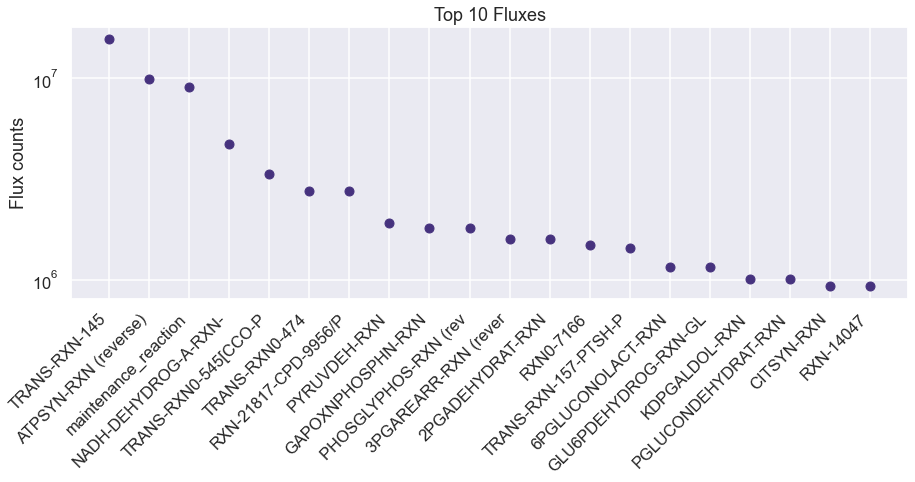

In [84]:
cur_fluxes = pd.Series(solution.velocities).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

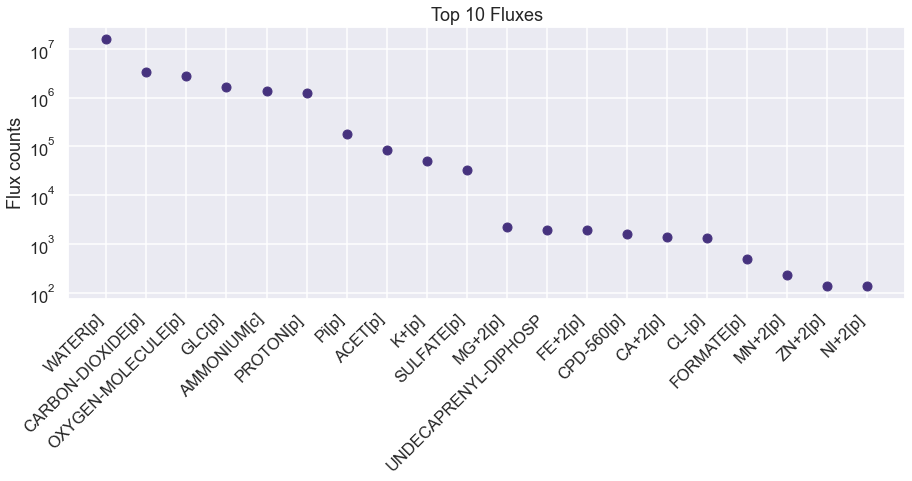

In [85]:
cur_exchanges = pd.Series(solution.exchanges).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()